In [1]:
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
from subprocess import Popen, PIPE, STDOUT
import gymnasium as gym
from gym import spaces
import time
from gymnasium.wrappers import TimeLimit
import tensorflow  as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import gym_wrapper
from tf_agents.environments import batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts
import tf_agents.environments.utils as utils
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import policy_saver

from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

In [89]:

class BasketballEnvTF(py_environment.PyEnvironment):

	def __init__(self,scenario = None):

		self.number_to_character = {'0' : 'Alice', '1':'Bob' , '2':'Charlie','3':'Sherlock','4':'?'}
		self.character_to_number = {v: k for k, v in self.number_to_character.items()}
													
		self.number_to_place = {'0' : 'HomeB', '1':'BasketballCourt' , '2':'Downtown','3':'?'}
		self.place_to_number = {v: k for k, v in self.number_to_place.items()}

		self.number_to_item = {'0' : 'Basketball', '1':'Bat','2':'?' }
		self.item_to_number = {v: k for k, v in self.number_to_item.items()}

		self.number_to_crime = {'0' : 'Theft', '1':'Murder','2':'?' }
		self.crime_to_number = {v: k for k, v in self.number_to_crime.items()}
		
		self.mind_level=0
		self.scenario = scenario
		
		self.score = 0
		self.characters = ['Alice', 'Bob', 'Charlie','Sherlock']
		self.items = ['Basketball','Bat']
		self.places= ['HomeB','BasketballCourt','Downtown']
		self.crimes = ['Theft','Murder']
		self.clues = ['Theft_Basketball_HomeB_clues',
			'Theft_Basketball_BasketballCourt_clues',
			'Theft_Basketball_Downtown_clues',
			'Theft_Bat_HomeB_clues',
			'Theft_Bat_BasketballCourt_clues',
			'Theft_Bat_Downtown_clues',
			'Murder_Basketball_HomeB_clues',
			'Murder_Basketball_BasketballCourt_clues',
			'Murder_Basketball_Downtown_clues',
			'Murder_Bat_HomeB_clues',
			'Murder_Bat_BasketballCourt_clues',
			'Murder_Bat_Downtown_clues']

		self.utilities = {
			'Alice':'1 - angry(Alice);\n',
			'Bob':'3 - (sum(c : citizen) angry(c));\n',
			'Charlie':'if(!alive(Alice)) 1 else 0;\n',
			'Sherlock':'(sum(p : place) searched(p)); \n',
		}

		self.chars_know = ['Alice_alive',
			'Alice_underArrest',
			'Alice_angry',
			'Alice_suspect', 
			'Alice_at', 
			'Bob_alive',
			'Bob_underArrest',
			'Bob_angry',
			'Bob_suspect',
			'Bob_at',
			'Charlie_alive',
			'Charlie_underArrest',
			'Charlie_angry',
			'Charlie_suspect',
			'Charlie_at',
			'Sherlock_alive',
			'Sherlock_underArrest',
			'Sherlock_angry',
			'Sherlock_suspect',
			'Sherlock_at',
			'HomeB_searched',
			'BasketballCourt_searched',
			'Downtown_searched',
			'Basketball_has',
			'Bat_has',
			'Theft_Basketball_HomeB_clues',
			'Theft_Basketball_BasketballCourt_clues',
			'Theft_Basketball_Downtown_clues',
			'Theft_Bat_HomeB_clues',
			'Theft_Bat_BasketballCourt_clues',
			'Theft_Bat_Downtown_clues',
			'Murder_Basketball_HomeB_clues',
			'Murder_Basketball_BasketballCourt_clues',
			'Murder_Basketball_Downtown_clues',
			'Murder_Bat_HomeB_clues',
			'Murder_Bat_BasketballCourt_clues',
			'Murder_Bat_Downtown_clues']
		self.acting_character = self.characters[0]
		self.additional_utility = None
		self.df_effects = pd.read_csv('..\\data\\basketball_effects_nn.csv')
		self.df_actions = pd.read_csv('..\\data\\df_actions.csv')
		self.df_exp = pd.read_csv('..\\data\\df_exp.csv')
		
		self.file = '..\\planners\\rl_planner3.txt'

		self.randomize_df()
		self.df = self.change_number_to_cat(self.df)
		self.create_file(self.df)
		self.no_solution = 0
		self.episode_steps = 0
		self._nb_features = len(self.df.index)

		self._observation_spec = array_spec.BoundedArraySpec(
			shape=(self._nb_features,), dtype=np.int32, minimum=-1, maximum=5, name='obs')

		self._action_spec = array_spec.BoundedArraySpec(
			shape=(), dtype=np.int32, minimum=0, maximum=6, name='action')
		
		
		self._action_values = {
			0: 'char0',
			1: 'char1',
			2: 'char2',
			3: 'ut_char3_1',
			4: 'ut_char3_2',
			5: 'mind_char0',
			6: 'mind_char1'
		}
		"""
		self._action_values = {
			0: 'char0',
			1: 'ut_char3_1',
			2: 'ut_char3_2',
			3: 'mind_char0',
			4: 'mind_char1'
		}
		"""
		self._episode_ended = False

	def _reset(self):
		print(self.scenario)
		
		print('reset!')
		#randomize row
		self.mind_level=0
		self.randomize_df()
		self.df = self.change_number_to_cat(self.df)
		self.create_file(self.df)
		self.no_solution = 0
		self.score = 0
		self.acting_character = self.characters[0]
		observation = self._get_obs() #turn row into observation
		info = self._get_info() #turn row into info
		
		self.episode_steps = 0
		self._episode_ended = False

		return ts.restart(observation)
	
	def _get_obs(self):
		
		df2 = self.change_cat_to_number(self.df) 
		r = df2.to_numpy(dtype='int32') 
		
			#print(len(r))
		return r

	def _get_info(self):
		return {0:'test'}

	def action_spec(self):
  		return self._action_spec
	
	def observation_spec(self):
  		return self._observation_spec
	
	def change_number_to_cat(self,row):
		for index,value in row.items():
			if (value != -1) and (type(value) != 'str') and (type(value) != 'object'):
				
				if ('acting_character' in index)  or ('has' in index) :
					if str(value) in self.number_to_character.keys():
						row[index] = self.number_to_character[str(value)]
				if ('suspect' in index) and str(value) != '?' :
					if str(value) in self.number_to_crime.keys():
						row[index] = self.number_to_crime[str(value)]
				elif 'at' in index and 'Bat' not in index:
					if str(value) in self.number_to_place.keys():
						row[index] = self.number_to_place[str(value)]

		return row

	def change_cat_to_number(self,row):
		for index,value in row.items():
			if value != -1:
				if ('acting_character' in index) or ('has' in index):
					if str(value) in self.character_to_number.keys():
						row[index] = self.character_to_number[str(value)]
				if ('suspect' in index) :
					if str(value) in self.crime_to_number.keys():
						row[index] = self.crime_to_number[str(value)]
				elif 'at' in index and 'Bat' not in index:
					if str(value) in self.place_to_number.keys():
						row[index] = self.place_to_number[str(value)]

		return row


	def randomize_df(self):
		if self.scenario != None:
			num = self.scenario
		else:
			num  = random.randint(-1, 10)
		print('scenario ',num)
		start_state =[]
		if num == 0 or num ==5:
			
			start_state = \
			[#alive,underArrest,angry,suspect,       at
				'1','0','1','2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'0','0','0',
				random.randint(0, 2),random.randint(0, 2),
				'0','0','0','0','0','0','0','0','0','0','0','0']

		

		elif num == 1 or num == 4 or num == 6 or num ==7:
			
			start_state = \
			[#alive,underArrest,angry,suspect,       at
				'1','0','1','2',random.randint(0, 2),
				'1','0','1','2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'0','0','0',
				random.randint(0, 2),random.randint(0, 2),
				'0','0','0','0','0','0','0','0','0','0','0','0']

		elif num == 2 or num ==8:
			
			start_state = \
			[#alive,underArrest,angry,suspect,       at
				'1','0','1','2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'0','0','0',
				random.randint(0, 2),random.randint(0, 2),
				'0','0','0','0','0','0','0','0','0','0','0','0']

		elif num == 3 or num ==9:
			
			start_state = \
				[#alive,underArrest,angry,suspect,       at
				'1','0','1','2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'0','0','0',
				random.randint(0, 2),random.randint(0, 2),
				'0','0','0','0','0','0','0','0','0','0','0','0']
		#special!!for testing
		elif num == 10 :
			
			start_state = \
			[#alive,underArrest,angry,suspect,       at
				'1','0','1','2','2',
				'1','0','0','2','1',
				'1','0','1','2','2',
				'1','0','0','2','2',
				'0','0','0',
				'1','2',
				'0','0','0','0','0','0','0','0','0','0','0','0']
		elif num == -1:

			start_state = \
			[#alive,underArrest,angry,suspect,       at
				'1','0','1','2','0',
				'1','0',random.randint(0, 1),'2','2',
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'1','0',random.randint(0, 1),'2',random.randint(0, 2),
				'0','0','0',
				'2','2',
				'0','0','0','0','0','0','0','0','0','0','0','0']
		

		start_state = [#alive,underArrest,angry,suspect,       at
				'1','0','1','2','2',
				'1','0','1','2','1',
				'1','0','1','2','2',
				'1','0','0','2','2',
				'0','0','0',
				'1','2',
				'0','0','0','0','0','0','0','0','0','0','0','0']
		not_character = ['Goal','Real']
		character = ['Alice','Bob','Charlie','Sherlock']

		
		
		
		state = {
		'mind_level' : 0,
		'goal_utility' : 1}

		for i,know in enumerate(self.chars_know,0):
			state['Goal:'+str(know)] = -1
			state['Real:'+str(know)] = start_state[i]

			for char in character:
				state[str(char)+'_believes:'+str(know)] = start_state[i]
		
		
		if num == 0 or num == -1:
			state['Goal:Alice_angry'] = 0

		elif num == 1:
			state['Goal:Bob_angry'] = 0
			
		elif num == 2:
			state['Goal:Alice_underArrest'] = 1
			
		elif num == 3 or num ==10:
			state['Goal:Charlie_underArrest'] = 1
		elif num == 4:
			#state['goal_utility'] = random.randint(1,2)
			state['Goal:Alice_angry'] = 0
			state['Goal:Bob_angry'] = 0
		elif num == 5:
			#state['goal_utility'] = random.randint(1,2)
			state['Goal:Alice_angry'] = 0
			state['Goal:Alice_alive'] = 0
		elif num == 6:
			#state['goal_utility'] = random.randint(1,2)
			state['Goal:Alice_angry'] = 0
			state['Goal:Charlie_underArrest'] = 1
		elif num == 7:
			#state['goal_utility'] = random.randint(1,2)
			state['Goal:Bob_angry'] = 0
			state['Goal:Charlie_underArrest'] = 1
		elif num == 8:
			#state['goal_utility'] = random.randint(1,2)
			state['Goal:Bob_angry'] = 0
			state['Goal:Alice_underArrest'] = 1
		elif num == 9:
			#state['goal_utility'] = random.randint(1,3)
			state['Goal:Bob_angry'] = 0
			state['Goal:Alice_angry'] = 0
			state['Goal:Charlie_underArrest'] = 1
		
		
		
		
		
		self.df = pd.Series(state )
		#print(self.df.to_string())
		
		
		
	def create_file(self,row):
		acting_character = self.acting_character
		with open(self.file, 'w') as f:
			f.write("""type item;
				type place;
				type basketballPlace : place;
				type arrestPlace : place;
				type crime; 
				type citizen : character;
				type police : character;
				type detective : police;
				type inspector : police;
				type world;

				property alive(character : character) : boolean;
				property underArrest(character : character) : number;
				property angry(character : character) : number;
				property searched(place : place) : number;
				property suspect(character : character, c : crime) : boolean;
				property clue(crime : crime, item : item, place : place) : boolean;
				property at(character : character) : place;
				property has(item : item) : character;
				property later(world : world) : boolean;

				entity Alice : citizen;
				entity Bob : citizen;
				entity Charlie : citizen;
				entity Sherlock : detective;
				entity HomeB : place;
				entity BasketballCourt : basketballPlace;
				entity Downtown : arrestPlace;
				entity Basketball : item;
				entity Bat : item;
				entity Theft : crime;
				entity Murder : crime;
				entity world:world;
						
						!later(world);

		   """
			)
			
			for char_act in self.characters:
				prefix = ''
				suffix =';\n'

				if char_act != self.acting_character:
					prefix = 'believes(' + str(char_act) + ','
					suffix =') ;\n'

				for char in self.characters:
					if str(row[char_act+'_believes:'+char+"_alive"]) == '1':
						f.write(prefix +"alive(" + char  +") " + suffix)
					else:
						f.write(prefix +"!alive(" + char  +") " + suffix)
					f.write(prefix + "underArrest(" + char  +") = " + str(row[char_act+'_believes:'+char+"_underArrest"]) + suffix)
					f.write(prefix + "angry(" + char  +") = " + str(row[char_act+'_believes:'+char+"_angry"]) + suffix)
					if str(row[char_act+'_believes:'+char+"_suspect"]) != '2' and str(row[char_act+'_believes:'+char+"_suspect"]) != '?':
						f.write(prefix + "suspect(" + char + ', '+ str(row[char_act+'_believes:'+char+"_suspect"]) +")   " + suffix)
					f.write( prefix + "at(" + char  +") = " + str(row[char_act+'_believes:'+char+"_at"]) +  suffix)

				
					
				for p in self.places:
					f.write( prefix + "searched(" + p  +") = " + str(row[char_act+'_believes:'+p+"_searched"]) + suffix)
					

				
				for i in self.items:
					f.write(prefix + "has(" + i  +") = " + str(row[char_act+'_believes:'+i+"_has"]) + suffix)
					
				
				for c in self.clues:
					if str(row[char_act+'_believes:'+c]) == '1':
						
						entities = c.split('_')
						f.write(prefix + "clue(" + entities[0]+","+entities[1]+","+ entities[2] +")" + suffix)
					#warrtosci postaci
			

				
				

			f.write("""
action travel(character : character, from : place, to : place){{
	precondition:
		from != to & 
		at(character) == from &
		alive(character)
		&character == {0};
	effect:
		later(world) &
		at(character) = to;
	consenting: character; 
	observing(c : character) : at(c) == from | at(c) == to; 
}};

action arrest(police : police, character : character, place : place, crime : crime){{
	precondition: 
		at(police) == place &
		at(character) == place &
		police != character &
		alive(police) &
		alive(character) &
		suspect(character, crime)&police == {0};
	effect:
		   later(world) &
		underArrest(character) = 1;
	consenting: police;
	observing(a : character) : at(a) == place;
}};

action steal(thief : citizen, victim : citizen, item : item, place : place){{
	precondition:
		at(thief) == place &
		at(victim) == place &
		has(item) == victim &
		thief != victim &
		alive(thief)&thief == {0};
	effect:
		   later(world) &
		has(item) = thief &
		angry(victim) = 1 &
		clue(Theft, item, place);
	consenting: thief;
	observing(c : character) : (c == thief | c == victim) | (at(c) == place & place != Downtown); // crimes downtown aren't observed
}};

action play_basketball(player1 : citizen, player2 : citizen, place : basketballPlace){{
	precondition:
		player1 != player2 &
		at(player1) == place &
		alive(player1) &
		at(player2) == place &
		alive(player2) &
		player2 != Charlie &
		has(Basketball) == player1 & player1 == {0};
	effect:
		   later(world) &
		angry(player1) = 0 &
		angry(player2) = 0;
	consenting: player1;
	observing(c : character) : at(c) == place;
}};

action kill(killer : citizen, victim : citizen, item : item, place : place){{
	precondition:
		killer != victim &
		at(killer) == place &
		at(victim) == place &
		alive(killer) &
		alive(victim) &
		has(item) == killer &
		underArrest(killer) == 0 & killer == {0};
	effect:
		   later(world) &
		!alive(victim) &
		clue(Murder, item, place);
	consenting: killer;
	observing(c : character) : c == killer | (at(c) == place & place != Downtown); 
}};
	
action find_clues(police : police, crime : crime, item : item, place : place){{
	precondition:
		at(police) == place &
		alive(police)
		&police == {0};
	effect:
		   later(world) &
		searched(place) = 1 &
		if(clue(crime, item, place))
			believes(police, clue(crime, item, place));
	consenting: police;
	observing(c : character) : at(c) == place;
}};

action share_clues(police1 : police, police2 : police, crime : crime, item : item, place : place){{
	precondition:
		police1 != police2 &
		at(police1) == place &
		alive(police1) &
		at(police2) == place &
		alive(police2) &
		clue(crime, item, place) &police1 == {0} ;
	effect:
		   later(world) &
		believes(police2, clue(crime, item, place));
	consenting: police1;
	observing(c : character) : at(c) == place;
}};
 
action suspect_of_crime(police : police, citizen : citizen, crime : crime, item : item, place : place){{
	precondition:
		police != citizen &
		at(police) == place &
		alive(police) &
		at(citizen) == place &
		alive(citizen) &
		has(item) == citizen
		&police == {0} &
		exists(p : place) clue(crime, item, p);
	effect:
		   later(world) &
		suspect(citizen, crime);
	consenting: police;
	observing(c : character) : at(c) == place;
}};
trigger see_has(character : character, other : character, item : item, place : place){{
	precondition:
		at(character) == place &
		at(other) == place &
		has(item) == other &
		believes(character, has(item) != other);
	effect:
		believes(character, has(item) = other);
}};

trigger see_hasnt(character : character, other : character, item : item, place : place){{
	precondition:
		at(character) == place &
		at(other) == place &
		has(item) != other & 
		believes(character, has(item) == other);
	effect:
		believes(character, has(item) = ?);
}};

trigger see_at(character : character, other : character, place : place){{
	precondition:
		at(character) == place &
		at(other) == place &
		believes(character, at(other) != place);
	effect:
		believes(character, at(other) = place);
}};

trigger see_gone(character : character, other : character, place : place){{
	precondition:
		at(character) == place &
		at(other) != place &
		believes(character, at(other) == place);
	effect:
		believes(character, at(other) = ?);
}};

			""".format(acting_character))

			if self.mind_level == 1:
				df_act = self.df_actions[self.df_actions['char']!= self.acting_character]
				for index,row in df_act.iterrows():
					f.write(row.actions)
				
			
			f.write("utility(): \n ")
			f.write(self.utilities[acting_character])

			
		


			for char in self.characters:
				f.write("utility({}): \n ".format(char))
				f.write(self.utilities[char])
			
			
			f.close()

	def load_action(self,file):

		
		p = Popen(['java', '-jar', '..\\planners\\sabre.jar', '-p', file,'-el',"0","-h","h+",'-c','n',"-tl","3100"], stdout=PIPE, stderr=STDOUT)
		#p = Popen(['java', '-jar', 'lib\sabre.jar', '-p', file,'-el',"0",'-g',"","-tl","1000"], stdout=PIPE, stderr=STDOUT)

		lines=[]
		for line in p.stdout:
			lines.append(str(line, encoding='utf-8'))

		#print(lines)
		return lines[0].replace("\r\n","")

	def do_action(self,args):
		if len(args) > 0 and len(self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values) > 0:
			functions = self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values[0].split(';')
			for function in functions:
				parts = function.split(':')
				
				
				#choosing feature
				feature = parts[0]

				#choosing how feature is changed
				change = parts[1]

				for count,arg in enumerate(args,0):
					
						feature = feature.replace('arg'+str(count),arg)
					
						change = change.replace('arg'+str(count),arg)

				change = change.split("_")
				#print(feature)
				#print(change)

				chars_observing = self.get_chars_observing(args[0],args[1:])
				features_to_change = [char+'_believes' for char in chars_observing]
				features_to_change.append('Real')
				
				#Alice_believes:Alice_alive
				if change[0] == "=":
					for feat in features_to_change:

						for index in self.df.index:
							if (feat+':'+feature) in index and 'Goal' not in index:
								self.df[index] = change[1]
					#print(self.df[feature])
					
					
				elif change[0] == "+":
					self.df[feature] = int(self.df[feature].values[0]) + int(change[1])
				elif change[0] == "-":
					self.df[feature] = int(self.df[feature]) - int(change[1])
		
		
				#print(self.df.to)
				self.df = self.change_cat_to_number(self.df)
			

	def change_state(self,actions):
		
		
		
		
		if 'No solution' not in actions:
			actions = actions.split(') ')
			
			if len(actions) > 0:
				args = actions[0].replace("("," ").replace(")","").replace(",","")
				print(args)
				if ('key_action' not in args) :
					self.do_action(args.split(" "))
				
				return True
		
		return False

	def make_action(self,action):
		self.mind_level=0
		if 'mind_char' in action:
			char = action.split('_')[1]
			num = char.split('char')[1]
			self.acting_character = self.number_to_character[str(num)]
			print('mind level 1')
			print(self.acting_character)
			self.mind_level=1
		elif 'ut_char' in action:
			sp = action.split('ut_char')[1]
			char = sp.split('_')[0]
			ut =  sp.split('_')[1]
			self.acting_character = self.number_to_character[str(char)]
			print('utility',ut)
			print(self.acting_character)
			if ut == "1":
				self.utilities['Sherlock'] ='(sum(c : citizen) underArrest(c));'
			elif ut == "2":
				self.utilities['Sherlock'] = '(sum(p : place) searched(p));'
			
			#self.additional_utility = action
		elif 'char' in action:
			char = action.split('char')[1]
			self.acting_character = self.number_to_character[str(char)]
			print(self.acting_character)
		
		
		else: print("nie ma takiej akcji!")
		
		
		
		start = time.time()

		

		df_copy = self.change_number_to_cat(self.df.copy())
		df_copy['acting_char'] = self.acting_character
		
		
		
		df_exp_copy = self.df_exp.copy()
		df_exp_copy.drop('results',axis=1,inplace=True)

		

		matches = df_exp_copy[(df_exp_copy==list(df_copy)).all(axis=1)]
		
		
		
		
		
		
		if (len(matches) > 0) and (self.acting_character != 'Sherlock'):
			
			
		
			
			match_index = matches.iloc[0].name
			
			self.results = pd.DataFrame(self.df_exp).iloc[match_index].results

			
			
		else:
			
			self.create_file(self.change_number_to_cat(self.df))
			self.results = self.load_action(self.file)
			
			df_copy['results'] = self.results
			
			self.df_exp.loc[len(self.df_exp)] = list(df_copy)
			
			self.df_exp.to_csv('..\\data\\df_exp.csv',index=False)
		

		end = time.time()
		
		index = 0
		#self.df.loc[index,['results']] = self.results
		#self.df.loc[index,['time']] = (end-start)

		print(self.results)
		self.change_state(self.results)
		
	def get_reward(self):
		#stworzenie targetu na poczatku
		reward = -0.02
		#czy osiagnelismy target jesli tak to 1
		#sum1 = int(self.df['Alice_underArrest']) + int(self.df['Bob_underArrest']) + int(self.df['Charlie_underArrest'])
		#sum2 = int(self.df['Alice_angry']) + int(self.df['Bob_angry']) + int(self.df['Charlie_angry'])
		
		#print('charlie_arrest',self.df['Real:Charlie_underArrest'])
		sum = 0
		for know in self.chars_know:
			if str(self.df['Real:' + str(know)]) == str(self.df['Goal:' + str(know)]):
				sum +=1
				print('osiagniete')
		
		if sum  >= self.df['goal_utility']:
		#if str(self.df['Charlie_underArrest']) == '1' and :
			reward = 1
			print('sukces!')
		elif ('No solution' in self.results) or ('Time limit' in self.results) or ('predictaction' in self.results.split("(")[0]):
			print('kara!')
			reward = -0.05
			self.no_solution = self.no_solution+1
		else: 
			self.no_solution = 0
			
		#jesli nie to 0
		#jesli nie działa to minus
		#jesli to działa, to ustawienie samemu targetu, też w tabeli
		
		return reward

	def _step(self, action):    
		
		if self._episode_ended:
			return self.reset()
		
		
		action = action.item()					
		direction = self._action_values.get(action)
		#direction = 'char0'
		self.make_action(direction)
		self.check_triggers()

		terminated = False
		reward = self.get_reward()
		if reward > 0 :
			terminated = True
			print('sukces')
		if (self.episode_steps > 16):
			if (self.no_solution > 6) :print('nosolution')
			else:print('episodesteps')
			terminated = True
		self.score += reward
		observation = self._get_obs()
		info = self._get_info()

		self.episode_steps += 1
		if terminated:
			self._episode_ended = True
			return ts.termination(observation,reward)
		else:
			return ts.transition(observation, reward=reward, discount=1.0)

	def get_chars_observing(self,action,args):
		char_observing = [args[0]]
		
		for char in self.characters:
			if action == 'travel':
				if (self.df['Real:'+char+"_at"] == args[1]) | (self.df['Real:'+char+"_at"] == args[2]) :
					char_observing.append(char)
			elif action == 'arrest':
				if (self.df['Real:'+char+"_at"] == args[2]) :
					char_observing.append(char)	
			elif action == 'steal':
				if ((self.df['Real:'+char+"_at"] == args[2]) & (args[3] != 'Downtown')) | (args[1]==char):
					char_observing.append(char)	
			elif action == 'play_basketball':
				if (self.df['Real:'+char+"_at"] == args[2])  :
					char_observing.append(char)	
			elif action == 'kill':
				#if ((self.df['Real:'+char+"_at"] == args[3]) & (args[3] != 'Downtown')) | (args[1]==char):
				char_observing.append(char)	
			elif action == 'find_clues':
				if (self.df['Real:'+char+"_at"] == args[3])  :
					char_observing.append(char)	
				for clue in [x for x in self.clues if args[3] in x]:
					
					#print('Real:',clue,self.df['Real:'+clue])
					if (self.df['Real:'+clue] == '1') :
						#print('Real i jest w tej lokacji:'+clue)
						self.df[args[0]+'_believes:'+clue] = 1
						#print('believs',self.df[args[0]+'_believes:'+args[1]+"_"+args[2]+"_"+args[3]+"_clues"])
				
			elif action == 'suspect_of_crime':
				if (self.df['Real:'+char+"_at"] == args[4])  :
					char_observing.append(char)	
		#print('obsering:',char_observing)
		return char_observing
	
	def check_triggers(self):
		
		for char1 in self.characters:
			for char2 in self.characters:
				if (char1 != char2) & (self.df['Real:'+char1+"_at"] == self.df['Real:'+char2+"_at"]):
					for item in self.items:
						if self.df['Real:'+item+"_has"] == char2:
							self.df[char1+'_believes:'+item+"_has"] = char2
						elif  (self.df['Real:'+item+"_has"] != char2) & (self.df[char1+'_believes:'+item+"_has"] == char2):
							self.df[char1+'_believes:'+item+"_has"] = '?'

					self.df[char1+'_believes:'+char2+"_at"] = self.df['Real:'+char1+"_at"]

				elif  (char1 != char2) & (self.df['Real:'+char1+"_at"] != self.df['Real:'+char2+"_at"]) \
					& (self.df[char1+'_believes:'+char2+"_at"] == self.df['Real:'+char1+"_at"]):
					self.df[char1+'_believes:'+char2+"_at"] = '?'

In [143]:
batch_size = 2
env= BasketballEnvTF()
py_envs = [env for _ in range(0, batch_size)]
batched_env = batched_py_environment.BatchedPyEnvironment(envs=py_envs)
tf_env = tf_py_environment.TFPyEnvironment(batched_env)

scenario  1


In [90]:
python_environment = BasketballEnvTF()
tf_env = tf_py_environment.TFPyEnvironment(python_environment)

scenario  3


In [54]:
utils.validate_py_environment(python_environment, episodes=1)

None
reset!
scenario  2
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
travel Alice Downtown BasketballCourt
utility 2
Sherlock
find_clues(Sherlock, Theft, Basketball, Downtown)
find_clues Sherlock Theft Basketball Downtown
mind level 1
Alice
steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
steal Alice Bob Basketball BasketballCourt
utility 2
Sherlock
travel(Sherlock, Downtown, HomeB) find_clues(Sherlock, Theft, Basketball, HomeB)
travel Sherlock Downtown HomeB
Alice
play_basketball(Alice, Bob, BasketballCourt)
play_basketball Alice Bob BasketballCourt
mind level 1
Bob
steal(Bob, Alice, Basketball, BasketballCourt) play_basketball(Bob, Alice, BasketballCourt)
steal Bob Alice Basketball BasketballCourt
Bob
play_basketball(Bob, Alice, BasketballCourt)
play_basketball Bob Alice BasketballCourt
Charlie


KeyboardInterrupt: 

In [91]:
tempdir = 'tf_batchsize1_3layers200_nadam'

In [92]:
train_env = tf_py_environment.TFPyEnvironment(python_environment)
eval_env = tf_py_environment.TFPyEnvironment(python_environment)

In [57]:
train_env = tf_py_environment.TFPyEnvironment(batched_env)
eval_env = tf_py_environment.TFPyEnvironment(batched_env)

NameError: name 'batched_env' is not defined

In [93]:
fc_layer_params = [200,200,200]

q_net = q_network.QNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            fc_layer_params = fc_layer_params,
            activation_fn=tf.keras.activations.relu,
            
        )

In [94]:
train_step = tf.Variable(0)
update_period = 16
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001,  epsilon=0.00001)

epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
                initial_learning_rate=1.0, 
                decay_steps=250000 // update_period,
                end_learning_rate=0.01)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DdqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        target_update_period=2000,
        td_errors_loss_fn=tf.keras.losses.Huber(reduction="none"),
        gamma=0.99,
        train_step_counter=global_step,
        epsilon_greedy=lambda: epsilon_fn(global_step))

agent.initialize()

In [95]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=10000)

replay_buffer_observer = replay_buffer.add_batch

In [96]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=20,
    agent=agent,
    #policy=loaded_policy,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

In [97]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [98]:
train_metrics = [tf_metrics.NumberOfEpisodes(),tf_metrics.EnvironmentSteps(),tf_metrics.AverageReturnMetric(), tf_metrics.AverageEpisodeLengthMetric()]

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    #loaded_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period)

In [65]:
train_dir = os.path.join(tempdir, 'train')    
train_summary_writer = tf.summary.create_file_writer(
            train_dir, flush_millis=10000)
train_summary_writer.set_as_default()

In [66]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [100]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")
initial_collect_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())
#initial_collect_policy = loaded_policy
init_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(2000)],
    num_steps=2000)

final_time_step, final_policy_state = init_driver.run()

None
reset!
scenario  8
mind level 1
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
travel Alice Downtown BasketballCourt
utility 2
Sherlock
find_clues(Sherlock, Theft, Basketball, Downtown)
find_clues Sherlock Theft Basketball Downtown
Bob
play_basketball(Bob, Alice, BasketballCourt)
play_basketball Bob Alice BasketballCourt
osiagniete
sukces!
sukces
None
reset!
scenario  4
utility 2
Sherlock
find_clues(Sherlock, Theft, Basketball, Downtown)
find_clues Sherlock Theft Basketball Downtown
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
Bob
No solution exists.
kara!
Bob
No solution exists.
kara!
mind level 1
Bob
No solution exists.
kara!
mind level 1
Bob
No solution exists.
kara!
utility 2
Sherlock
travel(Sherlock, Downtown, HomeB) find_clues(Sherlock, Theft, Basketball, HomeB)
travel Sherlock Downtown HomeB
Charlie
No solution exists.
kara!
utility 1
Sherlock
travel(Sh

In [99]:
dataset = replay_buffer.as_dataset(sample_batch_size=64, num_steps=2, num_parallel_calls=3).prefetch(3)


In [100]:
all_train_loss = []
all_metrics = []

def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)
    iterator = iter(dataset)
    
    for iteration in range(n_iterations):
        current_metrics = []
        
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        
        train_loss = agent.train(trajectories)
        all_train_loss.append(train_loss.loss.numpy())

        for train_metric in train_metrics:
            train_metric.tf_summaries(train_step=iteration, step_metrics=train_metrics[:2])

        for i in range(len(train_metrics)):
            current_metrics.append(train_metrics[i].result().numpy())
            
        all_metrics.append(current_metrics)
        df_metrics = pd.DataFrame(all_metrics)
        df_metrics.to_csv(tempdir+'results4_goals1-3.csv')
        
        if iteration % 500 == 0:
            print("\nIteration: {}, loss:{:.2f}".format(iteration, train_loss.loss.numpy()))
            train_checkpointer.save(global_step)
            tf_policy_saver.save(policy_dir)
            for i in range(len(train_metrics)):
                print('{}: {}'.format(train_metrics[i].name, train_metrics[i].result().numpy()))

In [101]:
train_agent(150000)

None
reset!
scenario  7
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
travel Alice Downtown BasketballCourt


Alice
steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
steal Alice Bob Basketball BasketballCourt
Alice
play_basketball(Alice, Bob, BasketballCourt)
play_basketball Alice Bob BasketballCourt
osiagniete
sukces!
sukces
None
reset!
scenario  0
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
travel Alice Downtown BasketballCourt
mind level 1
Alice
steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
steal Alice Bob Basketball BasketballCourt
Alice
play_basketball(Alice, Bob, BasketballCourt)
play_basketball Alice Bob BasketballCourt
osiagniete
sukces!
sukces
None
reset!
scenario  9
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
travel Alice Downtown BasketballCourt
mind level 1
Bob
play_basketball(Bob, Alice, BasketballCourt)
pla

e:\Praca_magisterska\narrative_system\.venv\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: tf_batchsize1_3layers200_nadam\policy\assets


NumberOfEpisodes: 4
EnvironmentSteps: 16
AverageReturn: 0.9700000286102295
AverageEpisodeLength: 2.5
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
Alice
No solution exists.
kara!
nosolution
None
reset!
scenario  3
Charlie
kill(Charlie, Alice, Bat, Downtown)
kill Charlie Alice Bat Downtown
utility 1
Sherlock
suspect_of_crime(Sherlock, Charlie, Murder, Bat, Downtown) arrest(Sherlock, Charlie, Downtown, Murder)
suspect_of_crime Sherlock Charlie Murder Bat Downtown
utility 1
Sherlock
arrest(Sherlock, Charlie, Downtown, Murder)
arrest Sherlock Charlie Downtown Murder
osiagniete
sukces!
sukces
None
reset!
scenario  -1
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketbal

In [70]:
train_checkpointer.save(global_step)
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: tf_batchsize1_3layers200_nadam\policy\assets


e:\Praca_magisterska\narrative_system\.venv\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: tf_batchsize1_3layers200_nadam\policy\assets


In [71]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [72]:
avg_return_trained = column(all_metrics,2)
avg_ep_trained = column(all_metrics,3)

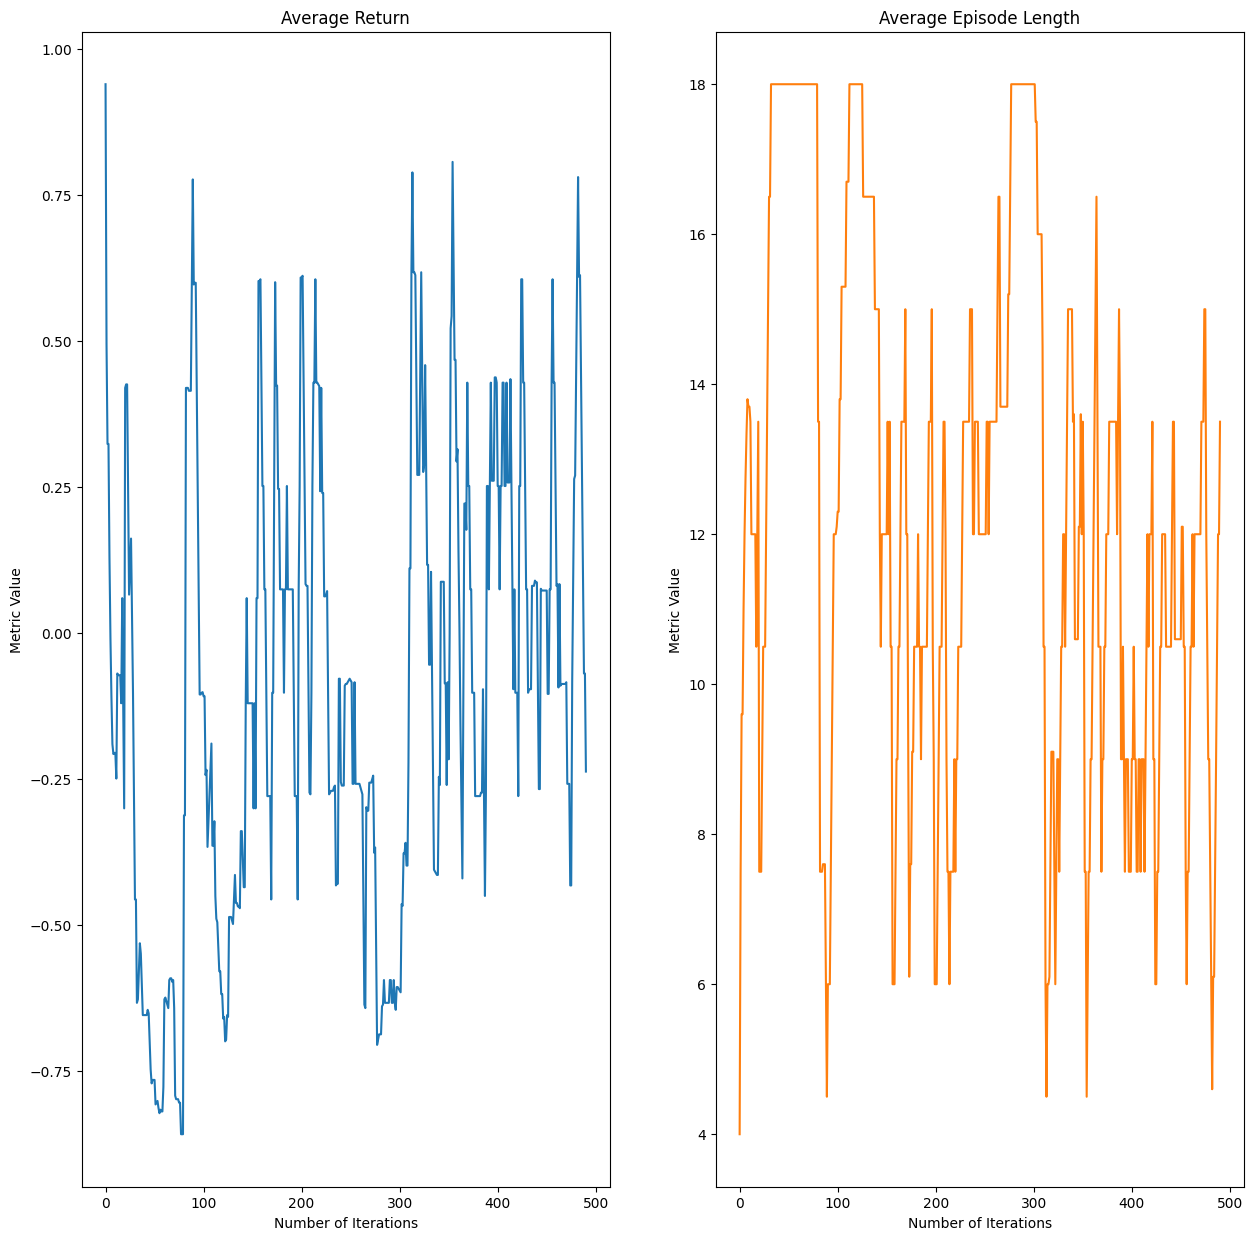

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].plot(range(len(avg_return_trained)), avg_return_trained)
axs[0].set_title('Average Return')

axs[1].plot(range(len(avg_ep_trained)), avg_ep_trained, 'tab:orange')
axs[1].set_title('Average Episode Length')

for ax in axs.flat:
    ax.set(xlabel='Number of Iterations', ylabel='Metric Value')

In [74]:
loaded_policy = tf.saved_model.load(tempdir+ '\policy')

In [75]:
eval_timestep = eval_env.reset()
loaded_action = loaded_policy.action(eval_timestep)
print(loaded_action)

None
reset!
scenario  2
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>, state=(), info=())


In [76]:
def compute_viz(environment, policy, num_episodes=1):

    total_return = 0.0
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        step = 0
        print("Step: 0")
        
        while not time_step.is_last():
            step += 1
            print("---\nStep: {}".format(step))
            action_step = policy.action(time_step)
            print("Action taken: {}".format(action_step.action))
            time_step = environment.step(action_step.action)
            #observation_viz(time_step.observation)
            episode_return += time_step.reward
            print("Reward: {} \n".format(episode_return))
        
        total_return += episode_return

    avg_return = total_return / num_episodes
    
    return avg_return.numpy()[0]

In [87]:
python_environment = BasketballEnvTF(6)
#0 ! angry Alice
#1 ! angry Bob
#3 Charlie underArrest
tf_env = tf_py_environment.TFPyEnvironment(python_environment)
train_env = tf_py_environment.TFPyEnvironment(python_environment)
eval_env = tf_py_environment.TFPyEnvironment(python_environment)

scenario  6


In [88]:
compute_viz(eval_env,loaded_policy)

6
reset!
scenario  6
Step: 0
---
Step: 1
Action taken: [0]
Alice
travel(Alice, Downtown, BasketballCourt) steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
travel Alice Downtown BasketballCourt
Reward: [-0.02] 

---
Step: 2
Action taken: [0]
Alice
steal(Alice, Bob, Basketball, BasketballCourt) play_basketball(Alice, Bob, BasketballCourt)
steal Alice Bob Basketball BasketballCourt
Reward: [-0.04] 

---
Step: 3
Action taken: [0]
Alice
play_basketball(Alice, Bob, BasketballCourt)
play_basketball Alice Bob BasketballCourt
osiagniete
sukces!
sukces
Reward: [0.96] 



0.96